In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/project_Yuming/codes')

Mounted at /content/drive


In [2]:
%%capture
!pip install ipython-autotime
!pip install torchdiffeq
!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng
!pip install latex
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
%load_ext autotime
%matplotlib inline

time: 1.99 ms (started: 2021-06-24 20:11:09 +00:00)


In [3]:
import utils
from core_training import train_loop_diff, train_loop_em_new
from viz_loss import loss_grad_vis_1d, loss_grad_vis_2d
# from tqdm import tqdm
from tqdm.auto import tqdm

from models import DEModel, DAModel, NNModel, Noise

# reflect real-time changes in other modules
import importlib
importlib.reload(utils)
importlib.reload(DEModel)
importlib.reload(DAModel)
importlib.reload(NNModel)
importlib.reload(Noise)

from utils import Timer
import copy
import math
import random
import torch
import torch.nn as nn
import numpy as np
from scipy.integrate import solve_ivp
from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rc

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device="cpu"
print(f"device: {device}")

device: cpu
time: 7.02 s (started: 2021-06-24 20:11:09 +00:00)


In [8]:
importlib.reload(sys.modules['core_training'])
importlib.reload(NNModel)
importlib.reload(DAModel)
from core_training import train_loop_diff, train_loop_em_new

# seed = 42
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)

x_dims = [20, 20, 20, 40, 40, 40, 80, 80, 80]
N_ensems = [50, 50, 1000, 50, 50, 1000, 100, 50, 1000]
localization_radius = [None, 5, None, None, 5, None, None, 5, None]
# x_dims = [80, 80, 80]
# N_ensems = [100, 50, 1000]
# localization_radius = [None, 5, None]

n_metaruns = len(N_ensems)

monitor_EnKFs = []
monitor_KFs = []
monitor_PFs = []

EnKF_res1 = []
PF_res1 = []
EnKF_res2 = []
PF_res2 = []

for nm in range(n_metaruns):
  x_dim = x_dims[nm]
  # true_a = torch.tensor(0.42)
  # true_ode_func = NNModel.Linear_ODE_single_var(x_dim, true_a).to(device)
  true_a = torch.tensor([0.3, 0.6, 0.1])
  a_dim = true_a.shape[0]
  true_ode_func = NNModel.Linear_ODE_diag(x_dim, true_a).to(device)
  u0 = 2*torch.ones(x_dim, device=device)
  t0 = 0.
  t_obs_step = 1.
  t_obs_end = 10.
  t_obs = torch.arange(t0, t_obs_end+t_obs_step, t_obs_step)[1:].to(device)

  # q = 0.01 if nm == 0 else 0.5
  # model_Q_true = Noise.AddGaussian(x_dim, torch.tensor(math.sqrt(q)), "scalar")
  q = 0.5
  model_Q_true = Noise.AddGaussian(x_dim, torch.sqrt(torch.tensor(q)), "scalar", q_shape=torch.tensor(1.))


  init_m = torch.zeros(x_dim, device=device)
  init_C_param = Noise.AddGaussian(x_dim, 4*torch.eye(x_dim), "full")

  indices = [i for i in range(x_dim)]
  # indices = [i for i in range(10)] if nm == 0 else [i for i in range(100)]
  # indices = [0]
  y_dim = len(indices)
  H_true = torch.eye(x_dim)[indices]
  # H_true = torch.randn(y_dim, x_dim)
  true_obs_func = NNModel.Linear(x_dim, y_dim, H_true).to(device)

  noise_R_true = Noise.AddGaussian(y_dim, torch.tensor(math.sqrt(q)), "scalar")

  seed = 42
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

  with torch.no_grad():
    out, y_obs, out_intermediate, t_intermediate = DEModel.generate_data(true_ode_func, true_obs_func, t_obs, u0, model_Q_true, noise_R_true, 
                                                  device=device, ode_method='euler', ode_options=dict(step_size=t_obs_step), adjoint=False, save_intermediate_step=True, t0=t0, time_varying_obs=False)

  enkf_kwargs = dict(ode_method='euler', ode_options=dict(step_size=t_obs_step), adjoint=False, save_intermediate_step=True, smooth_lag=0, t0=t0, 
              var_inflation=None, localization_radius=localization_radius[nm], compute_likelihood=True, likelihood_warmup=0, 
              linear_obs=True, time_varying_obs=False, save_first=True, simulation_type=0)

  def monitor(ode_func, model_Q_param, noise_R_param, neg_log_likelihood, test_neg_log_likelihood, test_mse, one_step_fs, nll_suro_em, algorithm, device):
    res = torch.zeros(0, device=device)
    res = torch.cat((res, ode_func.a.detach().clone().view(-1)))
    res = torch.cat((res, model_Q_param.q_true().detach().clone().view(-1)))
    res = torch.cat((res, model_Q_param.q_shape.detach().clone().view(-1)))
    # res = torch.cat((res, noise_R_param.q_true().detach().clone().view(-1)))
    res = torch.cat((res, neg_log_likelihood.mean().detach().clone().view(-1)))
    # if algorithm == "em":
    #   res = torch.cat((res, nll_suro_em.mean().detach().clone().view(-1)))
    return res.unsqueeze(dim=0)

  a_list = torch.tensor([[0.5, 0.5, 0.5]])
  # Q_list = utils.softplus_inv(torch.tensor([1e-2, 1e-1, 1e0, 0.5]))
  q_list = torch.tensor([1.])
  qs_list = torch.tensor([0.1])

  N_ensem = N_ensems[nm]

  l2_reg = None# lambda ode_func, model_Q_param: 3. * (model_Q_param.q_shape - 2.)**2

  lr = 5e-5
  lr2 = 1e-3
  monitor_EnKF = torch.zeros(0, device=device)
  for iter in range(1):
    learned_ode_func = NNModel.Linear_ODE_diag(x_dim, a_list[0].detach().clone()).to(device)
    learned_model_Q = Noise.AddGaussian(x_dim, q_list[0].detach().clone(), "scalar", q_shape=qs_list[0].detach().clone())
    optimizer = torch.optim.SGD([{'params':learned_ode_func.parameters(), 'lr':lr},
                               {'params':learned_model_Q.parameters(), 'lr':lr2}])
                              #  {'params':learned_noise_R.parameters(), 'lr':1e-2}])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.1)
    monitor_res = train_loop_diff(learned_ode_func, true_obs_func, t_obs, y_obs, out, out_intermediate, N_ensem, init_m, init_C_param, learned_model_Q, noise_R_true, device, optimizer, n_epochs=1000, 
                                  scheduler=None, l2_reg=l2_reg, batch_length=20, bs=1, print_every_n_epochs=None, test_every_n_epochs=None, method='enkf', monitor=monitor, clip_norm=None, tbptt=None, **enkf_kwargs)
    monitor_EnKF = torch.cat((monitor_EnKF, monitor_res.unsqueeze(0)))
  monitor_EnKFs.append(monitor_EnKF)

  lr = 5e-5
  lr2 = 1e-3
  monitor_KF = torch.zeros(0, device=device)
  for iter in range(1):
    learned_ode_func = NNModel.Linear_ODE_diag(x_dim, a_list[0].detach().clone()).to(device)
    learned_model_Q = Noise.AddGaussian(x_dim, q_list[0].detach().clone(), "scalar", q_shape=qs_list[0].detach().clone())
    optimizer = torch.optim.SGD([{'params':learned_ode_func.parameters(), 'lr':lr},
                               {'params':learned_model_Q.parameters(), 'lr':lr2}])
                              #  {'params':learned_noise_R.parameters(), 'lr':1e-2}])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.1)
    monitor_res = train_loop_diff(learned_ode_func, true_obs_func, t_obs, y_obs, out, out_intermediate, N_ensem, init_m, init_C_param, learned_model_Q, noise_R_true, device, optimizer, n_epochs=1000, 
                                  scheduler=None,l2_reg=l2_reg, batch_length=20, bs=1, print_every_n_epochs=None, test_every_n_epochs=None, method='kf', monitor=monitor, clip_norm=None, tbptt=None, **enkf_kwargs)
    monitor_KF = torch.cat((monitor_KF, monitor_res.unsqueeze(0)))
  monitor_KFs.append(monitor_KF)

  lr = 5e-5
  lr2 = 1e-3
  monitor_PF = torch.zeros(0, device=device)
  for iter in range(1):#iter in range(1): 
    learned_ode_func = NNModel.Linear_ODE_diag(x_dim, a_list[0].detach().clone()).to(device)
    learned_model_Q = Noise.AddGaussian(x_dim, q_list[0].detach().clone(), "scalar", q_shape=qs_list[0].detach().clone())
    optimizer = torch.optim.SGD([{'params':learned_ode_func.parameters(), 'lr':lr},
                              {'params':learned_model_Q.parameters(), 'lr':lr2}])
                              #  {'params':learned_noise_R.parameters(), 'lr':1e-2}])
                              
    # optimizer = torch.optim.Adam([{'params':learned_ode_func.parameters(), 'lr':1e-1}])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.1)
    monitor_res = train_loop_diff(learned_ode_func, true_obs_func, t_obs, y_obs, out, out_intermediate, N_ensem, init_m, init_C_param, learned_model_Q, noise_R_true, device, optimizer, proposal='optimal', adaptive_resampling=False, n_epochs=1000, 
                                  scheduler=None,l2_reg=l2_reg, batch_length=20, bs=1, print_every_n_epochs=None, test_every_n_epochs=None, method='pf', monitor=monitor, clip_norm=None, tbptt=None, **enkf_kwargs)
    monitor_PF = torch.cat((monitor_PF, monitor_res.unsqueeze(0)))
  monitor_PFs.append(monitor_PF)

  mean, std = utils.mean_and_std(torch.linalg.norm(monitor_EnKF[0,-100:,0:3] - monitor_KF[0,-1,0:3], dim=-1))
  EnKF_res1.append((round(mean*100,4), round(2*std*100,4)))
  mean, std = utils.mean_and_std(torch.linalg.norm(monitor_EnKF[0,-100:,3:5] - monitor_KF[0,-1,3:5], dim=-1))
  EnKF_res2.append((round(mean*100,4), round(2*std*100,4)))

  mean, std = utils.mean_and_std(torch.linalg.norm(monitor_PF[0,-100:,0:3] - monitor_KF[0,-1,0:3], dim=-1))
  PF_res1.append((round(mean*100,4), round(2*std*100,4)))
  mean, std = utils.mean_and_std(torch.linalg.norm(monitor_PF[0,-100:,3:5] - monitor_KF[0,-1,3:5], dim=-1))
  PF_res2.append((round(mean*100,4), round(2*std*100,4)))

# monitor_EnKF = torch.cat(monitor_EnKFs, dim=-1)
# monitor_KF = torch.cat(monitor_KFs, dim=-1)
# monitor_PF = torch.cat(monitor_PFs, dim=-1)


Streaming output truncated to the last 5000 lines.
         -6.0562e+02]])
Epoch 340: nll = -605.6245727539062, test_nll = 0.0
tensor([[ 3.3624e-01,  5.5965e-01,  1.3664e-01,  7.3291e-01,  8.5658e-01,
         -6.0562e+02]])
Epoch 350: nll = -605.6246337890625, test_nll = 0.0
tensor([[ 3.3619e-01,  5.5973e-01,  1.3661e-01,  7.3289e-01,  8.5655e-01,
         -6.0562e+02]])
Epoch 360: nll = -605.6245727539062, test_nll = 0.0
tensor([[ 3.3614e-01,  5.5980e-01,  1.3660e-01,  7.3287e-01,  8.5652e-01,
         -6.0562e+02]])
Epoch 370: nll = -605.6246337890625, test_nll = 0.0
tensor([[ 3.3609e-01,  5.5986e-01,  1.3659e-01,  7.3285e-01,  8.5649e-01,
         -6.0562e+02]])
Epoch 380: nll = -605.6245727539062, test_nll = 0.0
tensor([[ 3.3605e-01,  5.5991e-01,  1.3658e-01,  7.3284e-01,  8.5646e-01,
         -6.0562e+02]])
Epoch 390: nll = -605.6245727539062, test_nll = 0.0
tensor([[ 3.3601e-01,  5.5996e-01,  1.3658e-01,  7.3282e-01,  8.5643e-01,
         -6.0562e+02]])
Epoch 400: nll = -605.624

In [ ]:
monitor_res = [*monitor_EnKFs, monitor_PFs[2]]

time: 967 µs (started: 2021-06-22 04:30:27 +00:00)


In [ ]:
utils.mean_and_std(torch.linalg.norm(monitor_EnKF[0,-100:,0:3] - monitor_KF[0,-1,0:3], dim=-1))
utils.mean_and_std(torch.linalg.norm(monitor_EnKF[0,-100:,3:5] - monitor_KF[0,-1,3:5], dim=-1))

(0.57979256, 0.030103372)

time: 11.8 ms (started: 2021-06-18 17:37:12 +00:00)


In [ ]:
torch.save({'EnKF_res1':EnKF_res1, 'EnKF_res2':EnKF_res2, 'PF_res1':PF_res1, 'PF_res2':PF_res2}, 
           f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Linear/80_learn")

time: 333 ms (started: 2021-06-18 23:02:05 +00:00)


In [9]:
print(EnKF_res1)
print(EnKF_res2)
print(PF_res1)
print(PF_res2)

[(1.6526, 0.3007), (0.5253, 0.1843), (0.0715, 0.0546), (4.1158, 0.7261), (0.3543, 0.2716), (0.1737, 0.0919), (4.1419, 0.6692), (1.0451, 0.3757), (0.1945, 0.1353)]
[(38.0085, 1.7155), (22.329, 0.4192), (1.8593, 0.2798), (56.5788, 4.6208), (24.2824, 1.452), (2.8688, 0.2721), (57.9793, 6.0207), (23.1346, 1.7371), (5.7089, 1.1041)]
[(7.7488, 0.3649), (7.7488, 0.3649), (3.5049, 0.3455), (8.5765, 0.245), (8.5765, 0.245), (5.5866, 0.3103), (8.4681, 0.3848), (9.2786, 0.4934), (6.7709, 0.2402)]
[(64.0911, 1.6921), (64.0911, 1.6921), (49.8588, 1.4095), (48.5709, 2.3866), (48.5709, 2.3866), (39.4055, 2.2347), (50.0672, 2.538), (52.2285, 2.6223), (45.1904, 2.9845)]
time: 5.84 ms (started: 2021-06-24 21:29:25 +00:00)


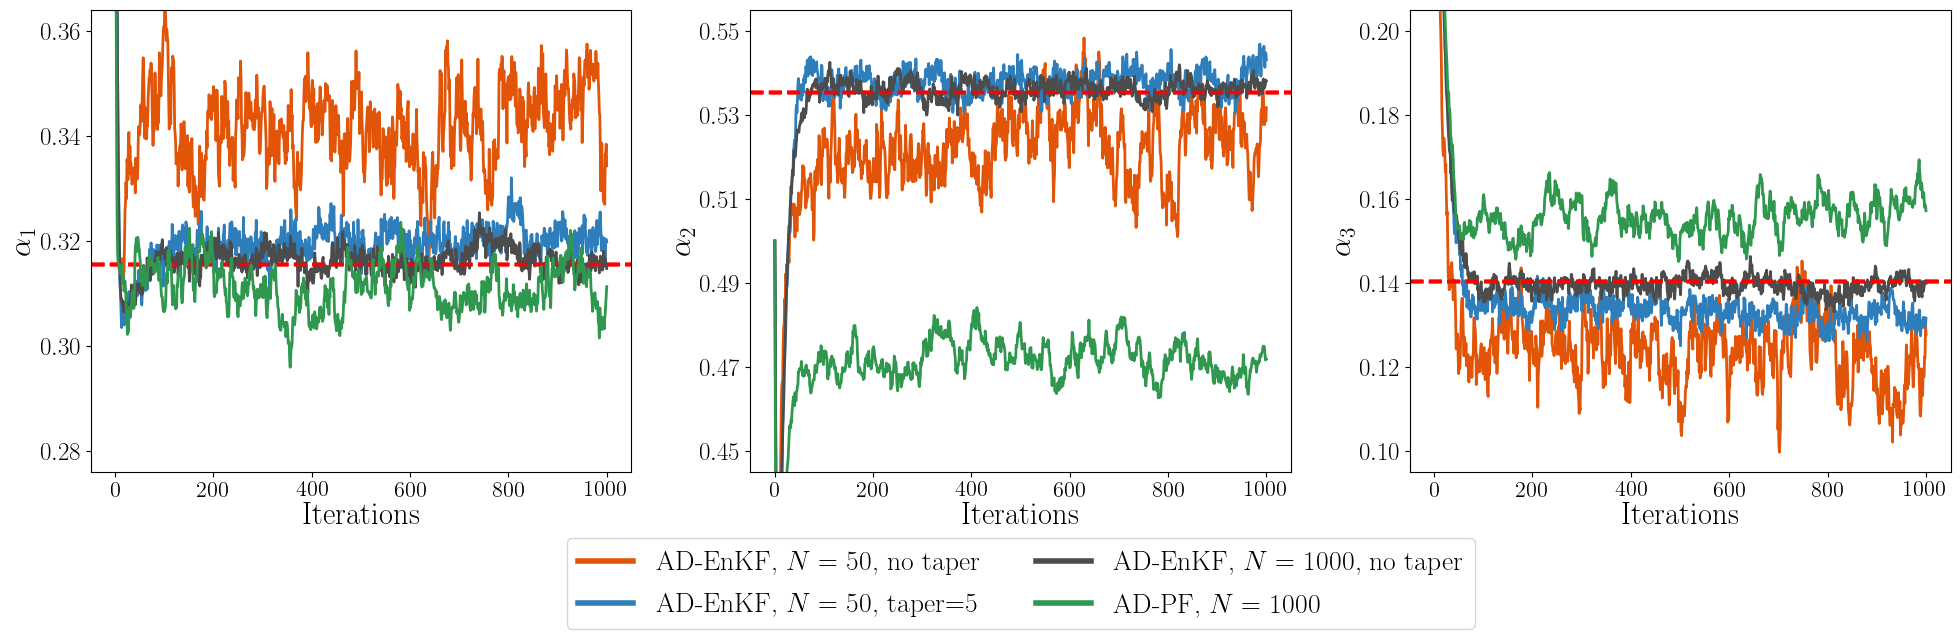

time: 627 ms (started: 2021-06-22 04:30:51 +00:00)


In [ ]:
importlib.reload(utils)

mpl.rc_file_defaults()
rc('font', **{'family':'serif','serif':'Computer Modern'})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams['axes.titlesize']= 24
mpl.rcParams['axes.grid']= False
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize']= 18
mpl.rcParams['legend.fontsize']= 20


def custom_axes(axes, ax_d):
  axes[0,0].get_legend().remove()
  leg=axes[0,1].legend(loc='lower center',bbox_to_anchor=(0.5, -0.37), ncol=2)
  axes[0,2].get_legend().remove()
  utils.set_lim_ticks(axes[0,0], 0.28, 0.36,5)
  utils.set_lim_ticks(axes[0,1], 0.45, 0.55,6)
  utils.set_lim_ticks(axes[0,2], 0.1, 0.2,6)
  axes[0,0].set_xlabel(r"Iterations")
  axes[0,1].set_xlabel(r"Iterations")
  axes[0,2].set_xlabel(r"Iterations")
  axes[0,0].set_ylabel(r"$\alpha_1$")
  axes[0,1].set_ylabel(r"$\alpha_2$")
  axes[0,2].set_ylabel(r"$\alpha_3$")
  for line in leg.get_lines():
    line.set_linewidth(4.0)

  # axes[0,0].get_legend().remove()
  # leg=axes[0,1].legend(loc='lower center',bbox_to_anchor=(0.5, -0.37), ncol=2)
  # axes[0,2].get_legend().remove()
  # utils.set_lim_ticks(axes[0,0], 0.7, 1.1,5)
  # utils.set_lim_ticks(axes[0,1], 0.2, 1.0,5)
  # utils.set_lim_ticks(axes[0,2], -1350, -1200,4)
  # axes[0,0].set_xlabel(r"Iterations")
  # axes[0,1].set_xlabel(r"Iterations")
  # axes[0,2].set_xlabel(r"Iterations")
  # axes[0,0].set_ylabel(r"$\beta_1$")
  # axes[0,1].set_ylabel(r"$\beta_2$")
  # axes[0,2].set_ylabel(r"Training log-likelihood")
  # axes[0,2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
  # for line in leg.get_lines():
  #   line.set_linewidth(4.0)

  return

monitor_KF_truths=monitor_KF[0,-1,:]
monitor_EnKF_new=monitor_EnKF.detach().clone()
monitor_PF_new=monitor_PF.detach().clone()
# monitor_EnKF_new[:,:,0]=torch.abs(monitor_EnKF_new[:,:,0]-monitor_KF_truths[0])
# monitor_PF_new[:,:,0]=torch.abs(monitor_PF_new[:,:,0]-monitor_KF_truths[0])
# monitor_EnKF_new[:,:,3]=torch.abs(monitor_EnKF_new[:,:,3]-monitor_KF_truths[3])
# monitor_PF_new[:,:,3]=torch.abs(monitor_PF_new[:,:,3]-monitor_KF_truths[3])
# monitor_EnKF_new[:,:,1]=monitor_EnKF_new[:,:,1]**2
# monitor_PF_new[:,:,1]=monitor_PF_new[:,:,1]**2
# monitor_EnKF_new[:,:,4]=monitor_EnKF_new[:,:,4]**2
# monitor_PF_new[:,:,4]=monitor_PF_new[:,:,4]**2

save_location=None
load_location=None
# save_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Linear/80_learn_beta"
# torch.save({'monitor_EnKF': monitor_EnKF, 'monitor_KF':monitor_KF, 'monitor_PF': monitor_PF},
#            save_location+"_raw")
# load_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Linear/param_est"

# monitor_res = [monitor_KF,monitor_EnKF, monitor_PF]
monitor_res = monitor_res# [monitor_EnKF_new,monitor_PF_new]#,monitor_PF-monitor_KF]
# methods = [ r"Diff-EnKF",r"Diff-PF"]
methods = [ r"AD-EnKF, $N=50$, no taper",r"AD-EnKF, $N=50$, taper=5", r"AD-EnKF, $N=1000$, no taper", r"AD-PF, $N=1000$"]
# titles = ["Likelihood estimate", "grad"]
titles = [None, None, None, None, None, None]
# truths = [None,math.sqrt(0.5),None,0.42,math.sqrt(0.01),None]
truths = [None, None, None, None, None, None]
truths_legends = ['t','t',None,'t','t',None]
truths2 = [monitor_KF_truths[0], monitor_KF_truths[1], monitor_KF_truths[2], monitor_KF_truths[3], monitor_KF_truths[4], monitor_KF_truths[5]]
truths2_legends =None#['MLE', 'MLE', None, None, None, None]

colors_list = [cm.Oranges, cm.Blues, cm.binary, cm.Greens]

groups = None#[(0,3)]
plots_to_show = [0,1,2]#[3,4,5]
subplot_groups=None#((0,2),(0,1))
ax_d = None#{1:(0,1), 2:(1,1)}
logscale={}#{0,1,2}
logscalex={}
legend_order=None
utils.plot_monitor_res_new(monitor_res, methods, titles, truths, logscale, logscalex, truths_legends=truths_legends, truths2=truths2, truths2_legends=truths2_legends, start_from_one={2}, colors_list=colors_list, groups=groups, plots_to_show=plots_to_show, subplot_groups=subplot_groups, ax_d=ax_d,
                           subplots_adjust=0.22, plot_truth_first=True,legend_order=legend_order, error_bar=False, error_bar_style="quantile", n_cols=3,subplot_width=8, subplot_height=6,linewidth=2, x_axiss=None, custom_axes=custom_axes, save_location=save_location, load_location=load_location)